In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import *
import time

%matplotlib inline

In [2]:
#This loop only using the data with unique personID
df = pd.read_csv('df.csv')

In [3]:
df['re-entry'].sum()/9823

0.48610404153517256

In [4]:
def split_data(df, indepv):
    '''
    Split the data into training and testing set
    
    And save them to run try different models
    '''
    y = df['re-entry']
    x = df[indepv]
    # get train/test data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=1234)
    
    return x_train, x_test, y_train, y_test

In [5]:
clfs = {'RF': RandomForestClassifier(),
    'Boost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)),
    'Logit': LogisticRegression(),
    'SVM': SVC(probability=True, random_state=0),
    'Tree': DecisionTreeClassifier(),
    'Bag': BaggingClassifier(),
    'KNN': KNeighborsClassifier() 
    }
    
small_grid = {'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'Boost': {'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000]},
    'Logit': {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10]},
    'SVM' :{'C' :[0.01,0.1,1,10],'kernel':['linear']},
    'Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [5,10,20,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5]},
    'Bag':{'n_estimators':[1,10,20,50], 'max_samples':[5,10], 'max_features': [5,10]},
    'KNN' :{'n_neighbors': [1,10,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
    }


def generate_binary_at_k(y_scores, k):
    '''
    Set first k% as 1, the rest as 0.
    '''
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary


def scores_at_k(y_true, y_scores, k):
    '''
    For a given level of k, calculate corresponding
    precision, recall, and f1 scores.
    '''
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = precision_score(y_true, preds_at_k)
    recall = recall_score(y_true, preds_at_k)
    f1 = f1_score(y_true, preds_at_k)
    return precision, recall, f1


def plot_precision_recall_n(y_true, y_score, model_name):
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    
    name = model_name
    plt.title(name)
    plt.savefig(name)
    plt.show()
    

def plot(y_test, y_pred_probs, model, para = None):

    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve for {} model: AUC={:.2f} \n with parameters: {}'.\
                        format(model, average_precision_score(y_test, y_pred_probs), para))
    plt.show()
    

def clf_loop(models, x_train, x_test, y_train, y_test):
    '''
    Run model with given params on x and y
    and print out the scores for comparison
    '''
    results_df = pd.DataFrame(columns=('model_type', 'parameters', 'accuracy','auc-roc', 'auc-pr', 'time', 'precision,recall,f1 at_5',
     'precision,recall,f1 at_10', 'precision,recall,f1 at_20'))
    for index, clf in enumerate([clfs[x] for x in models]):
        model_params = small_grid[models[index]]
        for p in ParameterGrid(model_params):
            try:
                start = time.time()
                clf.set_params(**p)
                y_pred_probs = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
                accuracy = clf.score(x_test, y_test)
                end = time.time()
                #Zip, unzip to ensure corresponding order
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))

                results_df.loc[len(results_df)] = [models[index], p, accuracy,
                                                    roc_auc_score(y_test, y_pred_probs),
                                                    average_precision_score(y_test, y_pred_probs), end-start,                                                     
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,20.0)]

                plot_precision_recall_n(y_test, y_pred_probs, models[index])
                
            except IndexError as e:
                print(e)
                continue
    return results_df

In [6]:
#4 GenerateFeatures/Predictors: discretize a continuous variable 
def discrete_val(df, cols, bins=4):
    '''
    Helper function to discrete the continueous variable in dataframe into 4 bins
    This function will return dictionary mapping column name to the bin values
    '''
    for col in cols:
        new = col+'_binned'
        df[new] = pd.cut(df[col], bins, include_lowest=True, labels = range(0,bins))
        df.drop([col], inplace=True, axis=1)
    return df

In [7]:
#generate dummy variable for specific column
def getting_dummy(df, col):
    '''
    Helper function to create dummy variables in dataframe for specific column
    This function will return dataframe
    '''
    dummies = pd.get_dummies(df[col]).rename(columns=lambda x: str(col)+ str(x))
    df = pd.concat([df, dummies], axis=1)
    df.drop([col], inplace=True, axis=1)
    return df

In [8]:
dummy_vals = ['bail_type', 'gender', 'race', 'arresting_agency']

In [9]:
for dummy in dummy_vals:
    df = getting_dummy(df, dummy)

In [10]:
df = discrete_val(df, ['age'], 8)

In [11]:
df.columns


Index(['bail_amt', 're-entry', 'city', 'state', 'zip', 'booking_days',
       'treatment_days', 'mental_health', 'bail_typeCA', 'bail_typeGPS',
       'bail_typeORCD', 'bail_typePR', 'bail_typeSUR', 'genderF', 'genderM',
       'raceA', 'raceB', 'raceI', 'raceW', 'arresting_agencyFAIRWAY P.D.',
       'arresting_agencyGARDNER P.D.',
       'arresting_agencyJOHNSON COUNTY PARK PATROL',
       'arresting_agencyJOHNSON COUNTY SHERIFF'S DEPARTMENT',
       'arresting_agencyKANSAS HIGHWAY PATROL',
       'arresting_agencyLAKE QUIVIRA P.D.', 'arresting_agencyLEAWOOD P.D.',
       'arresting_agencyLENEXA P.D.', 'arresting_agencyMERRIAM P.D.',
       'arresting_agencyMISSION P.D.', 'arresting_agencyOLATHE P.D.',
       'arresting_agencyOTHER AGENCY', 'arresting_agencyOVERLAND PARK P.D.',
       'arresting_agencyPRAIRIE VILLAGE P.D.',
       'arresting_agencyROELAND PARK P.D.', 'arresting_agencySHAWNEE P.D.',
       'arresting_agencySPRING HILL P.D.', 'arresting_agencyWESTWOOD P.D.',
       'ag

In [12]:
indepv = ['bail_amt',  'booking_days',
       'treatment_days', 'mental_health',  'bail_typeCA',
       'bail_typeGPS', 'bail_typeORCD', 'bail_typePR', 'bail_typeSUR',
       'genderF', 'genderM', 'raceA', 'raceB', 'raceI', 'raceW',
       'arresting_agencyFAIRWAY P.D.', 'arresting_agencyGARDNER P.D.',
       'arresting_agencyJOHNSON COUNTY PARK PATROL',
       "arresting_agencyJOHNSON COUNTY SHERIFF'S DEPARTMENT",
       'arresting_agencyKANSAS HIGHWAY PATROL', 'arresting_agencyLEAWOOD P.D.',
       'arresting_agencyLENEXA P.D.', 'arresting_agencyMERRIAM P.D.',
       'arresting_agencyMISSION P.D.', 'arresting_agencyOLATHE P.D.',
       'arresting_agencyOTHER AGENCY', 'arresting_agencyOVERLAND PARK P.D.',
       'arresting_agencyPRAIRIE VILLAGE P.D.',
       'arresting_agencyROELAND PARK P.D.', 'arresting_agencySHAWNEE P.D.',
       'arresting_agencySPRING HILL P.D.', 'arresting_agencyWESTWOOD P.D.',
       'age_binned']

In [13]:
x_train, x_test, y_train, y_test = split_data(df, indepv)

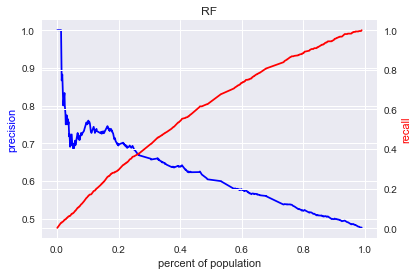

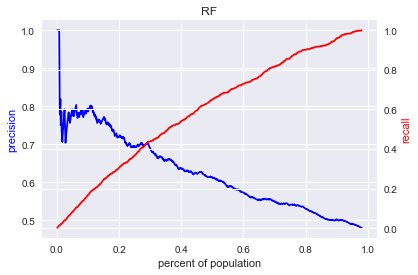

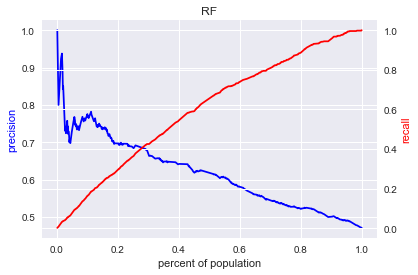

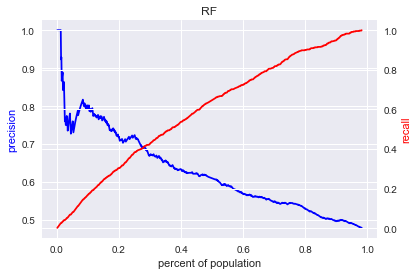

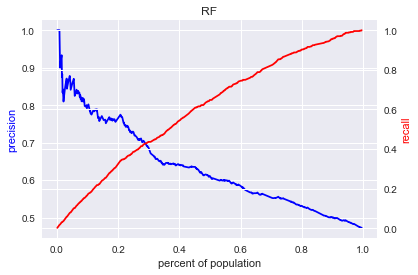

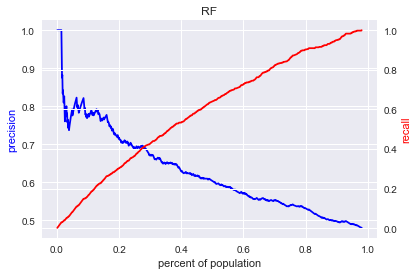

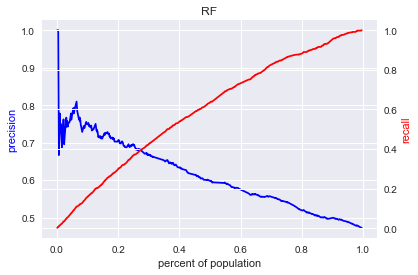

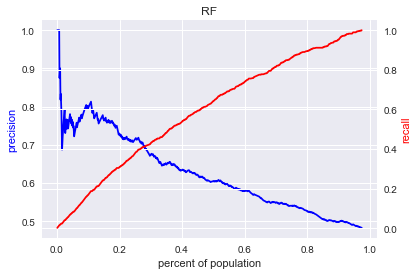

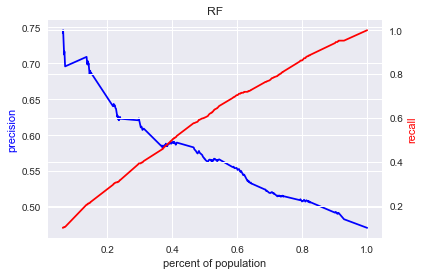

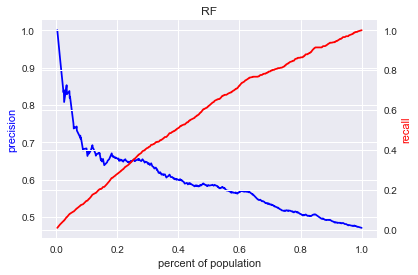

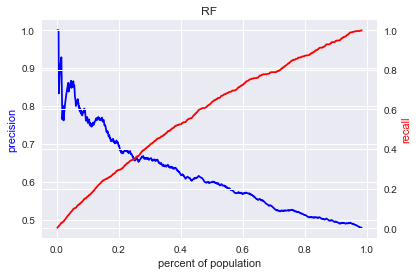

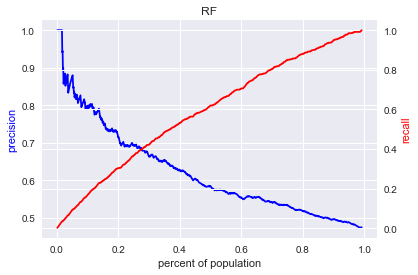

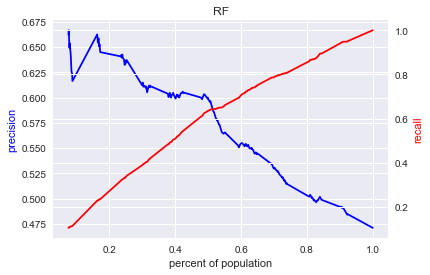

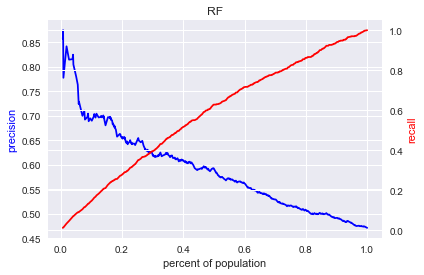

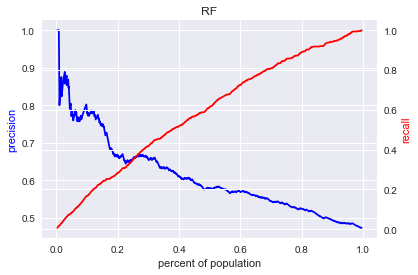

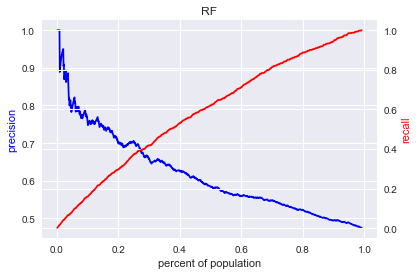

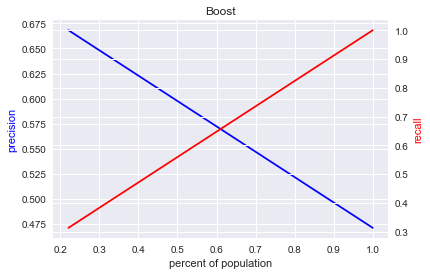

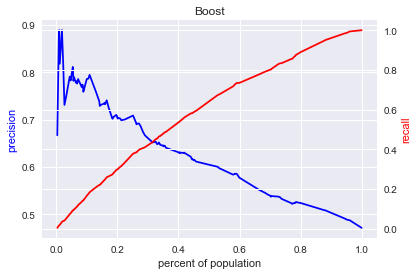

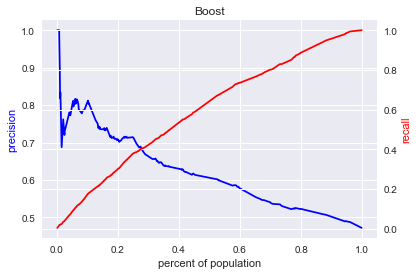

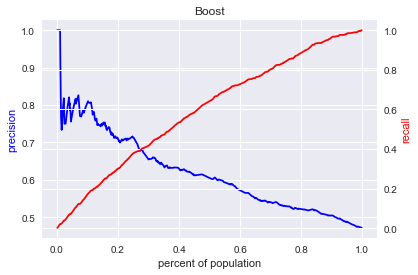

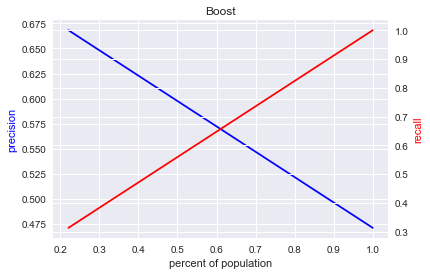

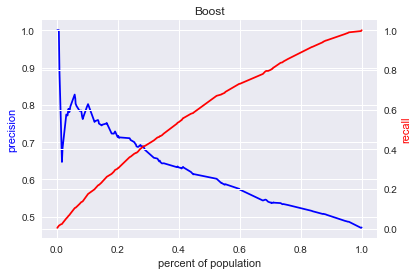

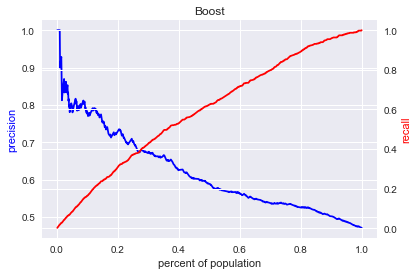

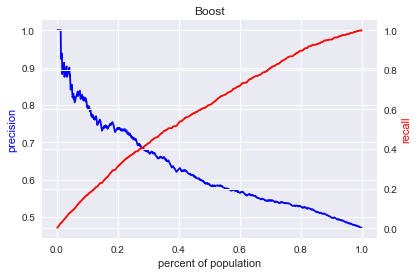

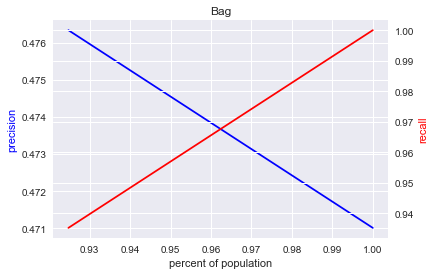

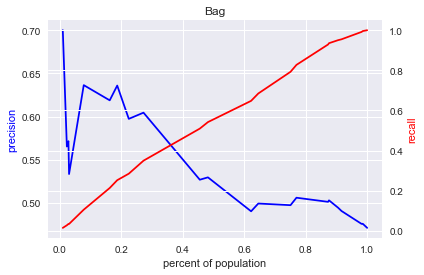

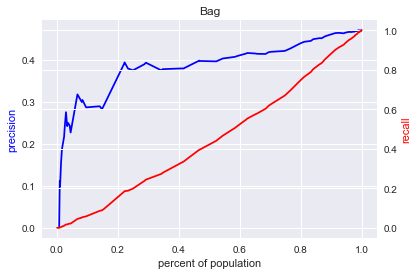

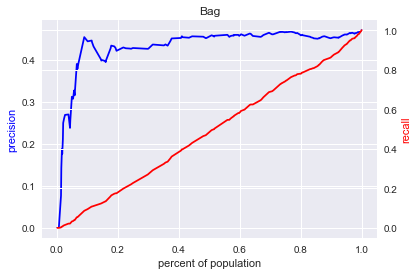

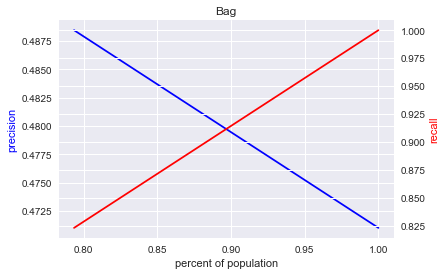

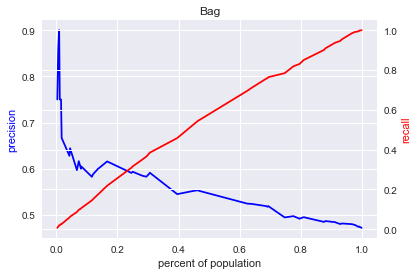

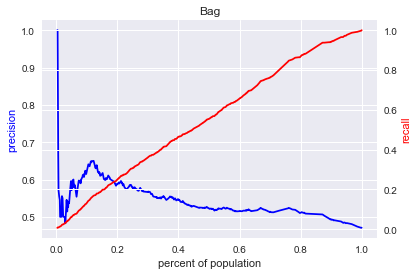

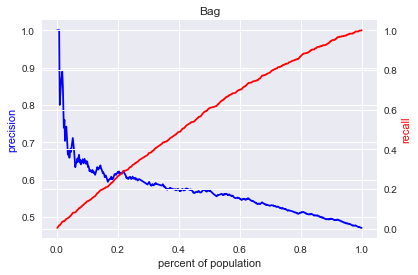

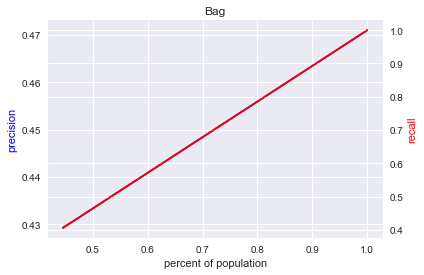

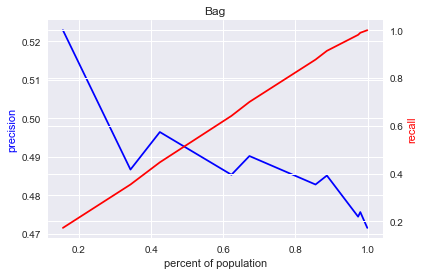

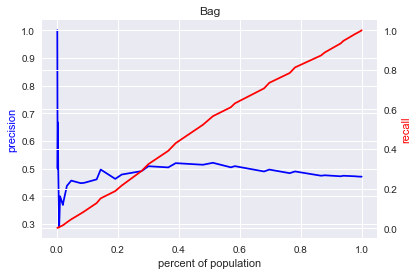

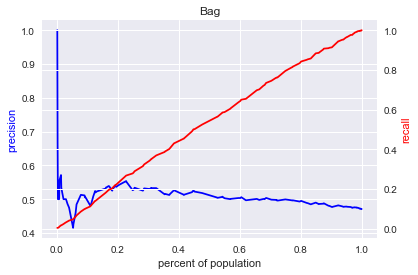

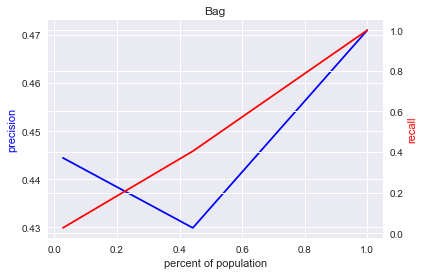

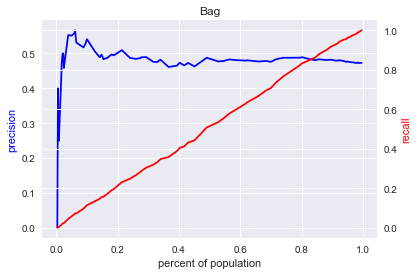

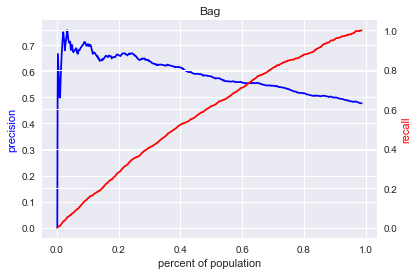

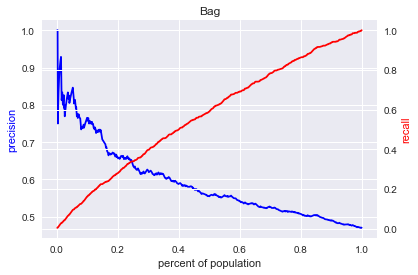

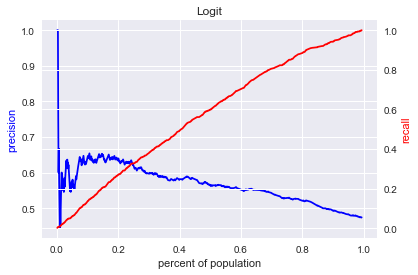

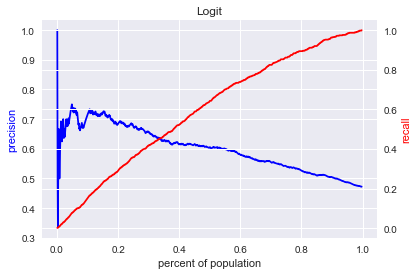

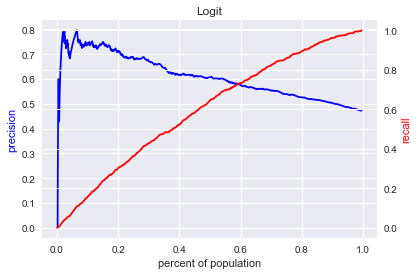

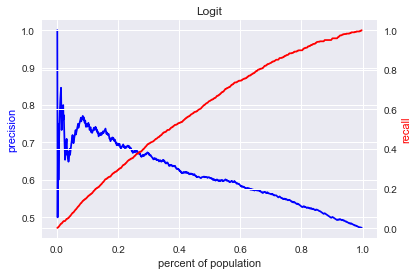

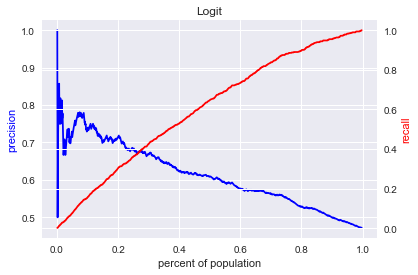

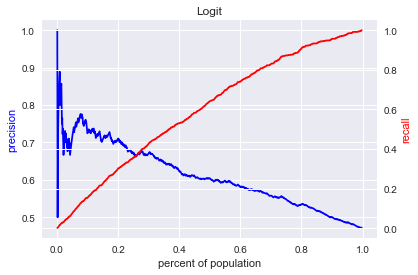

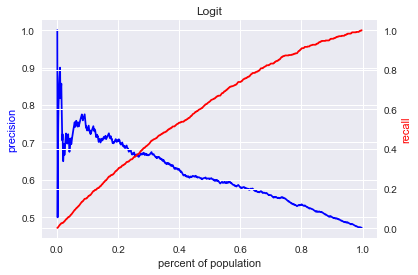

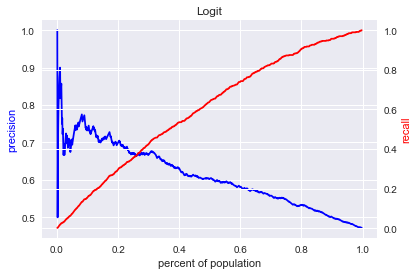

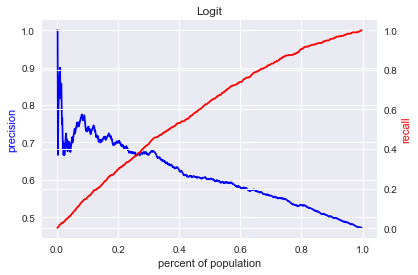

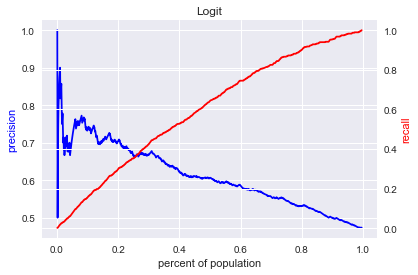

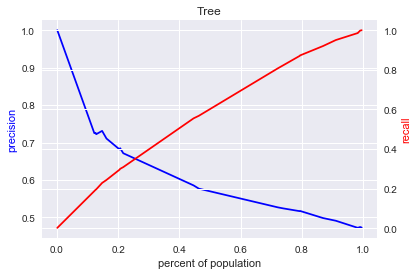

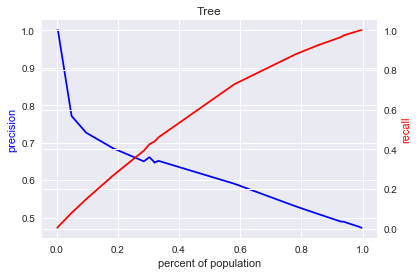

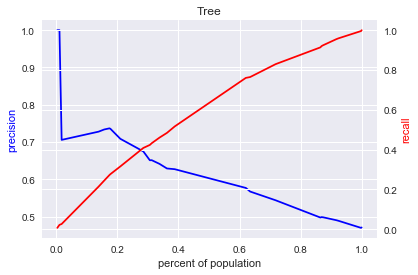

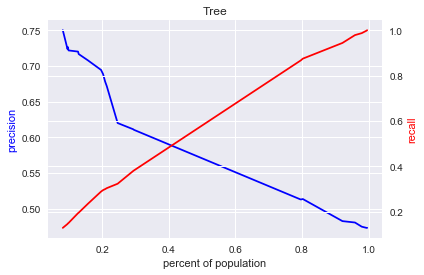

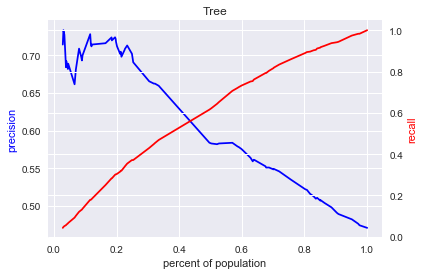

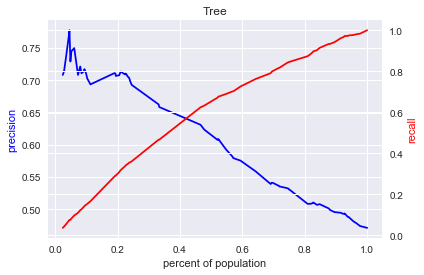

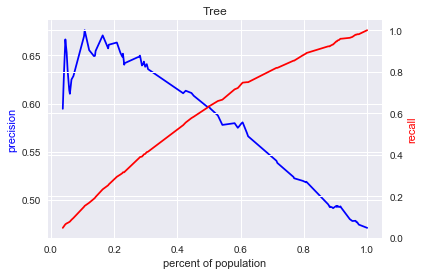

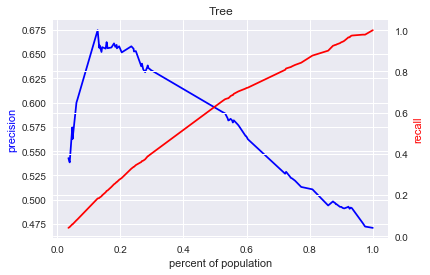

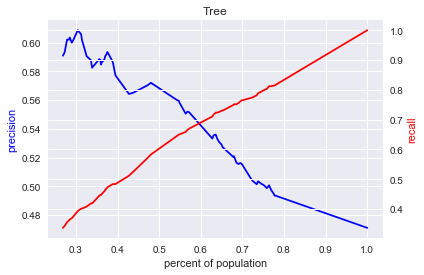

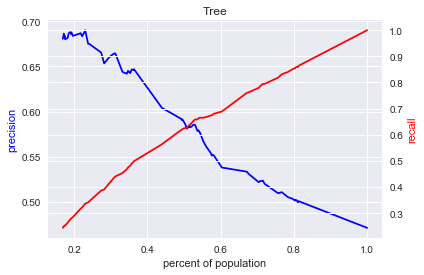

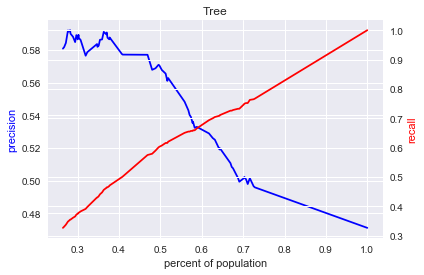

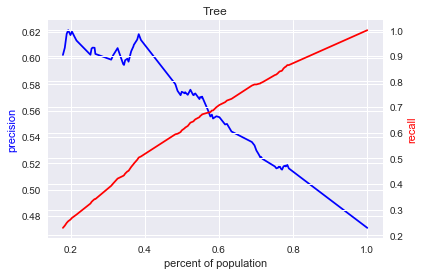

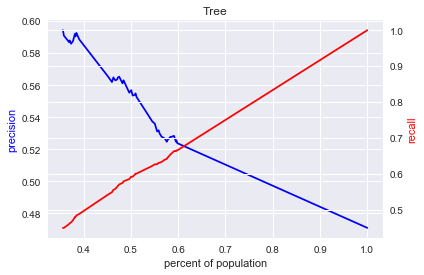

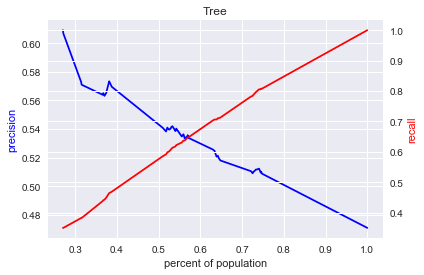

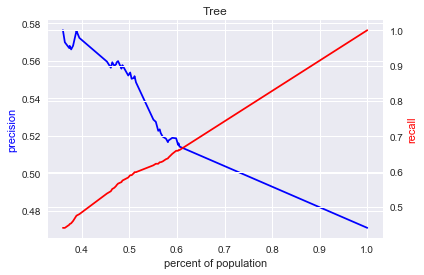

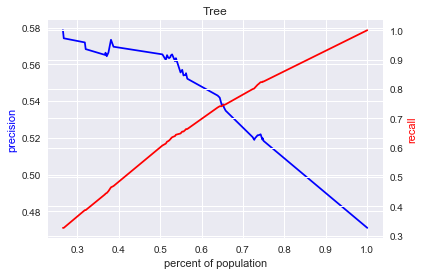

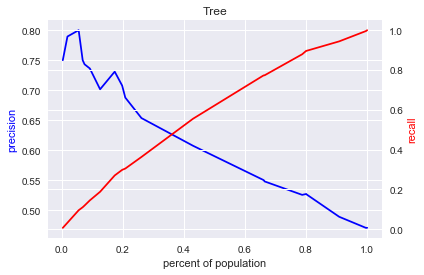

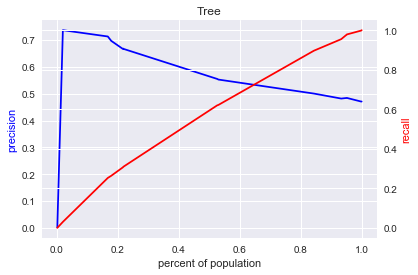

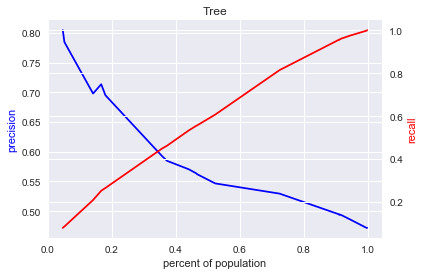

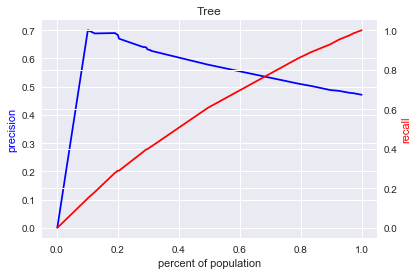

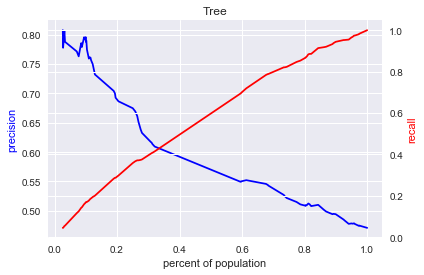

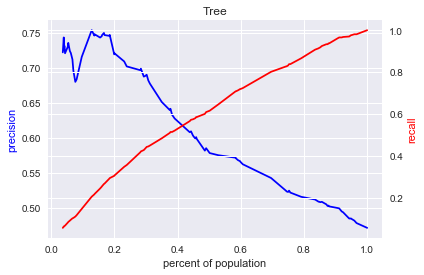

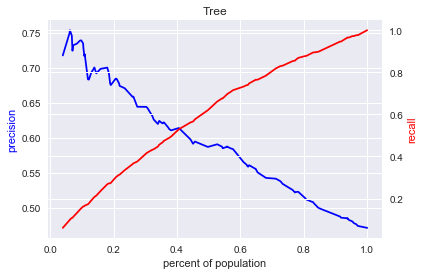

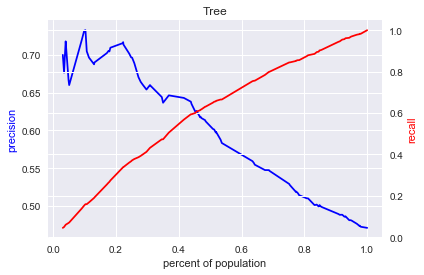

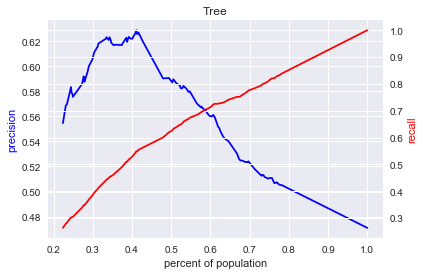

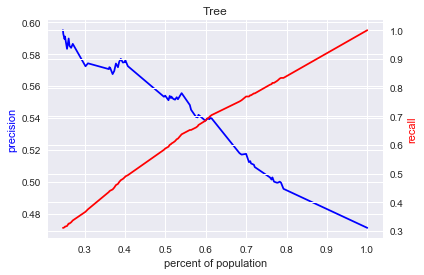

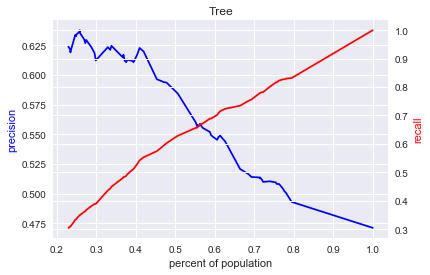

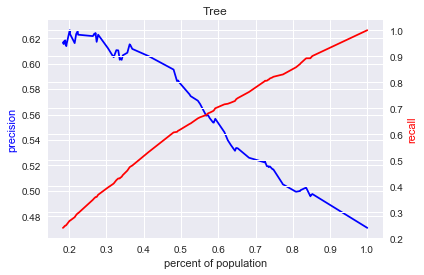

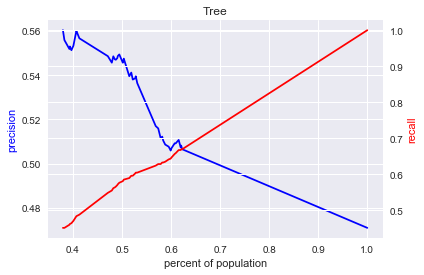

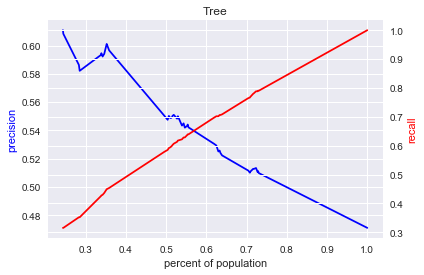

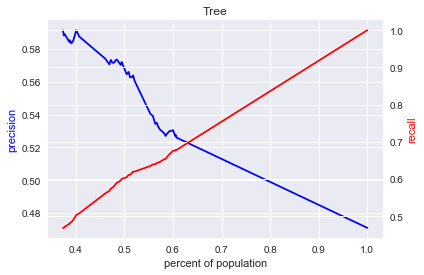

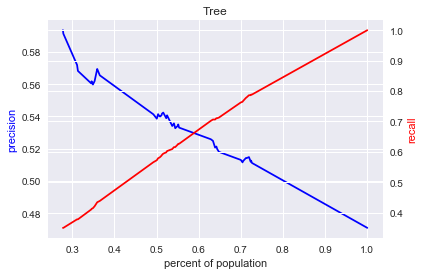

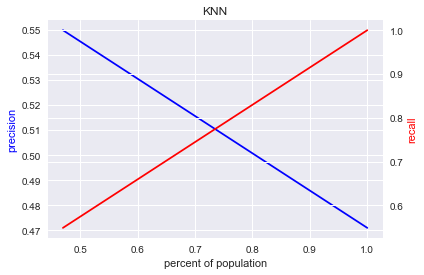

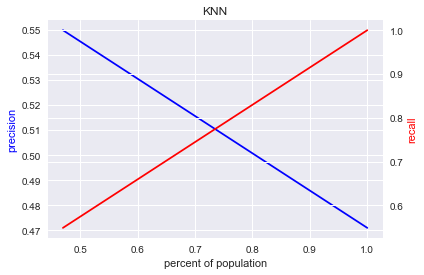

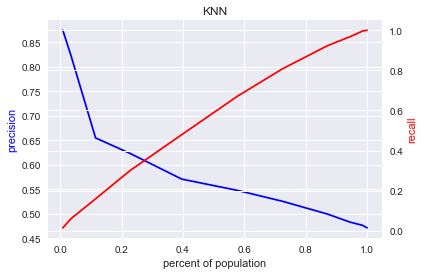

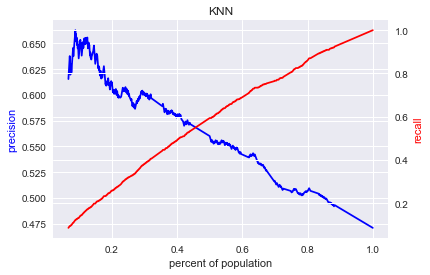

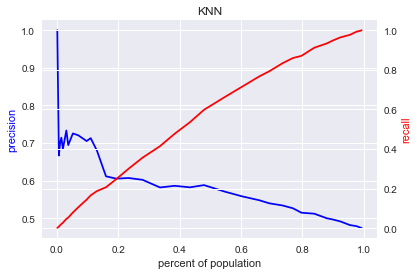

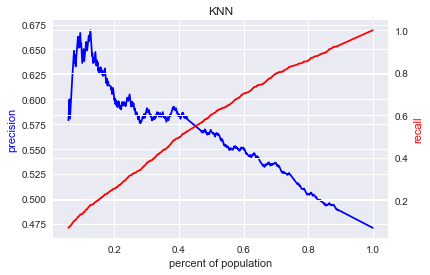

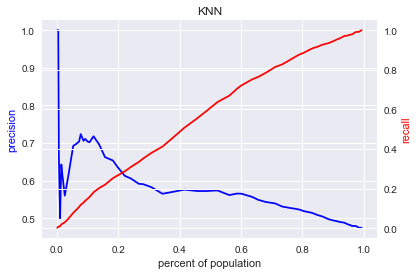

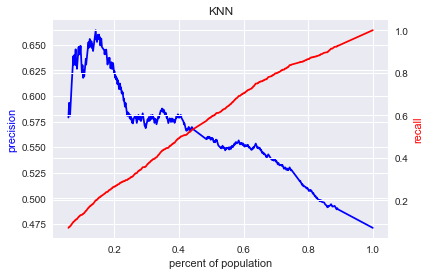

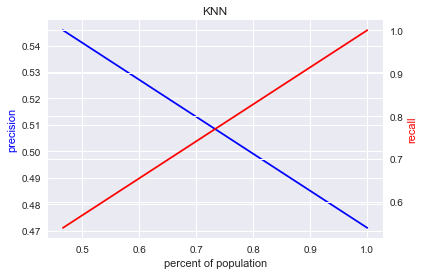

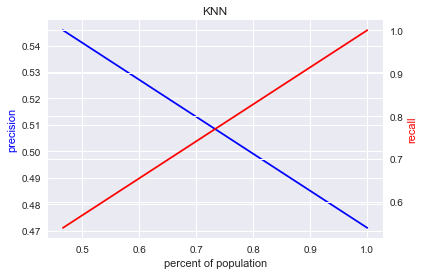

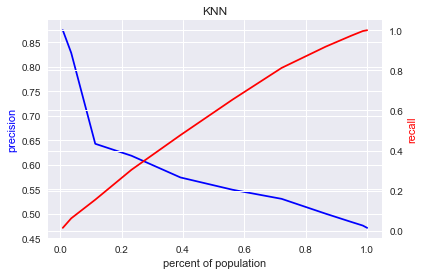

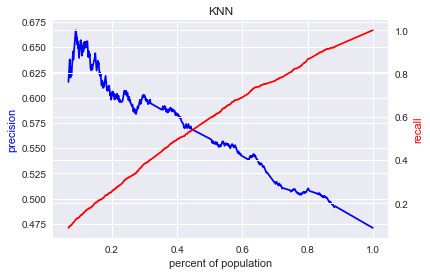

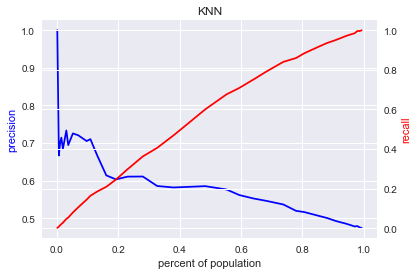

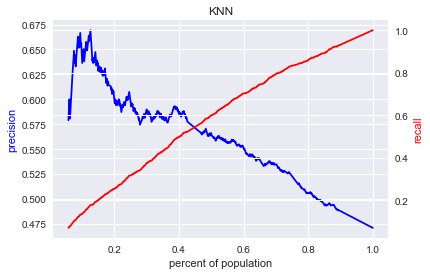

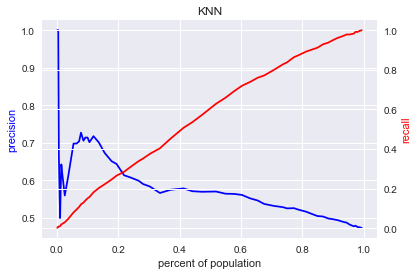

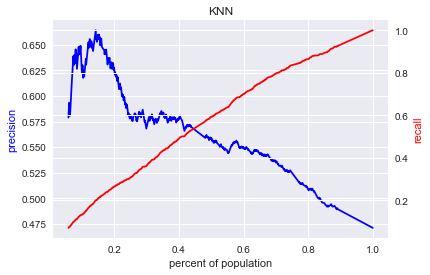

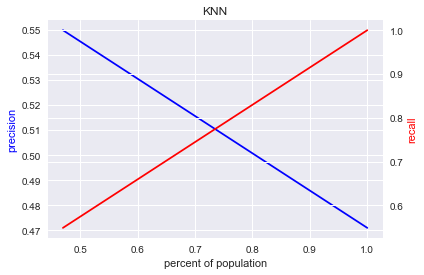

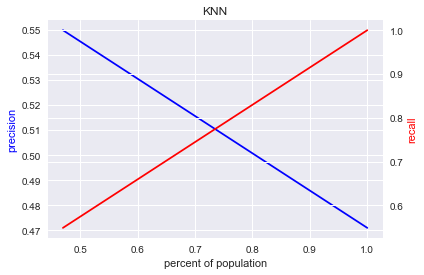

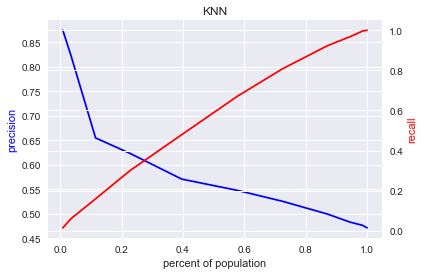

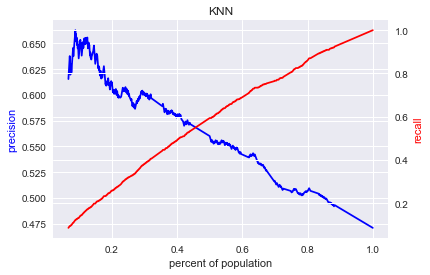

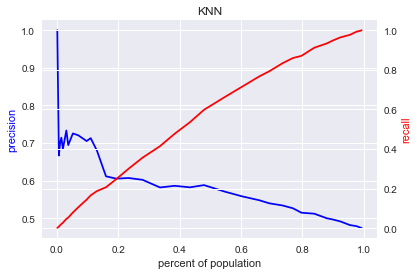

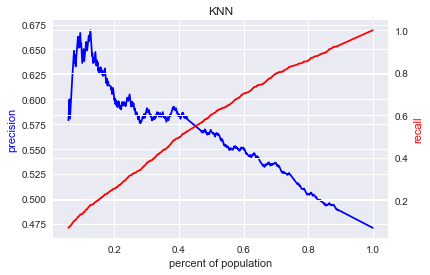

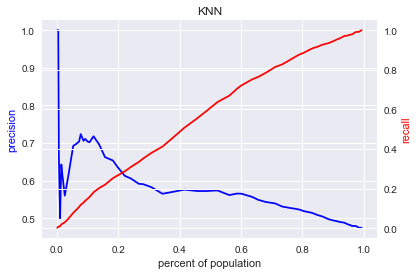

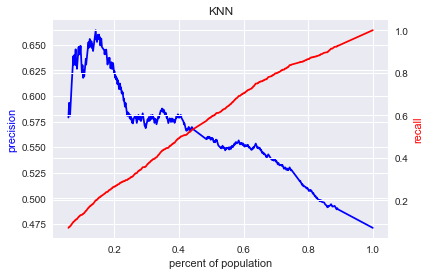

In [14]:
results = clf_loop(["RF", "Boost", "Bag", "Logit", "Tree", "KNN"], x_train, x_test, y_train, y_test)

In [15]:
from IPython.display import display
display(results)

,model_type,parameters,accuracy,auc-roc,auc-pr,time,"precision,recall,f1 at_5","precision,recall,f1 at_10","precision,recall,f1 at_20"
0,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.631740,0.682335,0.645602,0.079096,"(0.6938775510204082, 0.0734341252699784, 0.132...","(0.7551020408163265, 0.15982721382289417, 0.26...","(0.6938775510204082, 0.2937365010799136, 0.412..."
1,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.644964,0.690875,0.658532,0.327342,"(0.7755102040816326, 0.08207343412526998, 0.14...","(0.7857142857142857, 0.16630669546436286, 0.27...","(0.7193877551020408, 0.3045356371490281, 0.427..."
2,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.635809,0.689080,0.650455,0.052790,"(0.7346938775510204, 0.07775377969762419, 0.14...","(0.7755102040816326, 0.16414686825053995, 0.27...","(0.7040816326530612, 0.2980561555075594, 0.418..."
3,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.636826,0.690036,0.661960,0.371837,"(0.7551020408163265, 0.07991360691144708, 0.14...","(0.7959183673469388, 0.16846652267818574, 0.27...","(0.7193877551020408, 0.3045356371490281, 0.427..."
4,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.637843,0.699367,0.676242,0.061050,"(0.8571428571428571, 0.09071274298056156, 0.16...","(0.7959183673469388, 0.16846652267818574, 0.27...","(0.7653061224489796, 0.32397408207343414, 0.45..."
5,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.636826,0.686358,0.660821,0.299390,"(0.7755102040816326, 0.08207343412526998, 0.14...","(0.7755102040816326, 0.16414686825053995, 0.27...","(0.7142857142857143, 0.3023758099352052, 0.424..."
6,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.629705,0.680985,0.642273,0.057827,"(0.7755102040816326, 0.08207343412526998, 0.14...","(0.7551020408163265, 0.15982721382289417, 0.26...","(0.7040816326530612, 0.2980561555075594, 0.418..."
7,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.637843,0.690707,0.659068,0.403060,"(0.7551020408163265, 0.07991360691144708, 0.14...","(0.7959183673469388, 0.16846652267818574, 0.27...","(0.7295918367346939, 0.30885529157667385, 0.43..."
8,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.603255,0.633845,0.597301,0.102266,"(0.9387755102040817, 0.09935205183585313, 0.17...","(0.7857142857142857, 0.16630669546436286, 0.27...","(0.6989795918367347, 0.2958963282937365, 0.415..."
9,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.605290,0.649298,0.619513,0.986240,"(0.8367346938775511, 0.08855291576673865, 0.16...","(0.6836734693877551, 0.1447084233261339, 0.238...","(0.6683673469387755, 0.28293736501079914, 0.39..."


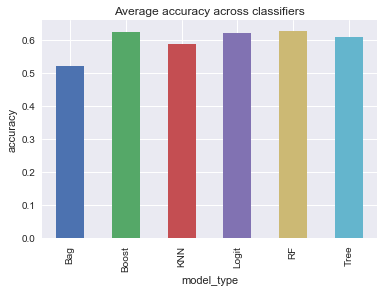

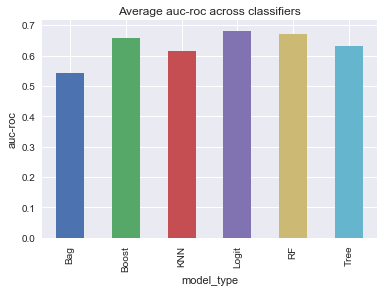

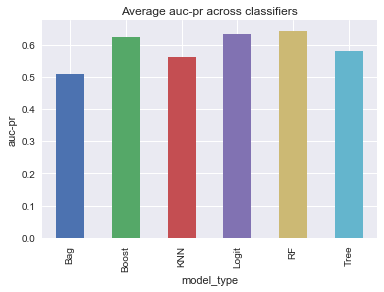

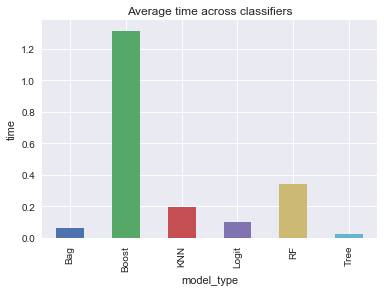

In [16]:
for item in ['accuracy', 'auc-roc','auc-pr','time']:
    plt.figure()
    results.groupby(['model_type'])[item].mean().plot(kind='bar', title='Average '+item+' across classifiers')
    plt.ylabel(item)

In [17]:
models = results.groupby('model_type')['auc-pr'].nlargest(1)

In [18]:
models

model_type    
Bag         39    0.618441
Boost       23    0.666388
KNN         94    0.592066
Logit       44    0.643327
RF          4     0.676242
Tree        71    0.631778
Name: auc-pr, dtype: float64

In [19]:
results.loc[[37,23,94,44,1,54]].iloc[:,0:6]

,model_type,parameters,accuracy,auc-roc,auc-pr,time
37,Bag,"{'max_features': 10, 'max_samples': 10, 'n_est...",0.509664,0.520080,0.487342,0.044246
23,Boost,"{'algorithm': 'SAMME.R', 'n_estimators': 1000}",0.623601,0.682761,0.666388,4.813681
94,KNN,"{'algorithm': 'ball_tree', 'n_neighbors': 50, ...",0.600203,0.643197,0.592066,0.268002
44,Logit,"{'C': 0.1, 'penalty': 'l1'}",0.626653,0.690243,0.643327,0.043697
1,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.644964,0.690875,0.658532,0.327342
54,Tree,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.614446,0.672936,0.621932,0.021075


In [20]:
results.loc[54]['parameters']

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 2}

In [21]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features='sqrt', min_samples_split=2)

In [22]:
tree = dt.fit(x_train, y_train)

In [23]:
tree_viz = export_graphviz(tree, out_file=None, feature_names=indepv, rounded=True, filled=True)
graph = graphviz.Source(tree_viz)

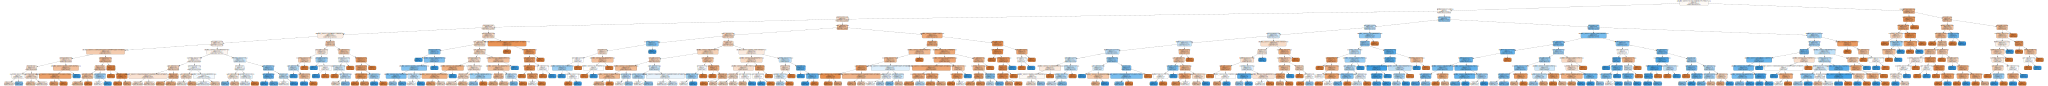

In [29]:
graph